# ✨ Exploratory Data Analysis on Immigration Dataset #
# Data Preprocessing
## 📌 Step 1: Import Required Libraries
Before diving into the dataset, we load all the necessary libraries used for data manipulation, visualization, and modeling.

In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import math
import os
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
import statsmodels.api as sm

%matplotlib inline  

## 📥 Step 2: Load the Merged Immigration Data
We load the cleaned and combined dataset that includes immigration records from multiple countries and years.

In [2]:
df = pd.read_excel("C:/Users/layas/OneDrive/Desktop/Layashree documents/NEU Cources/Intro to Programming in DS/output merged file/all_countries_merged.xlsx")
df.head(10)

,Total,Male,Female,Unknown,Year,Region,Group,Subgroup
0,4321.0,2193.0,2128.0,0.0,2014,Jamaica,Age,Under 18 years
1,2638.0,1324.0,1314.0,0.0,2014,Jamaica,Age,18 to 24 years
2,3517.0,1748.0,1769.0,0.0,2014,Jamaica,Age,25 to 34 years
3,3507.0,1529.0,1978.0,0.0,2014,Jamaica,Age,35 to 44 years
4,2887.0,1053.0,1834.0,0.0,2014,Jamaica,Age,45 to 54 years
5,1477.0,514.0,963.0,0.0,2014,Jamaica,Age,55 to 64 years
6,679.0,232.0,447.0,0.0,2014,Jamaica,Age,65 years and over
7,0.0,0.0,0.0,0.0,2014,Jamaica,Age,Unknown
8,1157.0,445.0,712.0,0.0,2014,Jamaica,Occupation,"Management, professional, and related occupations"
9,2136.0,985.0,1151.0,0.0,2014,Jamaica,Occupation,Service occupations


## 🔍 Step 3: Initial Data Inspection

In [3]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87532 entries, 0 to 87531
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Total     87532 non-null  float64
 1   Male      87532 non-null  float64
 2   Female    87532 non-null  float64
 3   Unknown   87532 non-null  float64
 4   Year      87532 non-null  int64  
 5   Region    87532 non-null  object 
 6   Group     87532 non-null  object 
 7   Subgroup  87532 non-null  object 
dtypes: float64(4), int64(1), object(3)
memory usage: 5.3+ MB


Total       0
Male        0
Female      0
Unknown     0
Year        0
Region      0
Group       0
Subgroup    0
dtype: int64

In [4]:
df.shape

(87532, 8)

## 🧹 Step 4: Data Cleaning – Filtering Years > 2005

The ‘Occupation’ subgroup classification changes significantly after 2005. To maintain consistency, we only use data post-2005.

In [5]:
df = df[df['Year'].astype(int) > 2005]

Now re-derive sorted unique values of Year and Region after filtering:

In [6]:
all_years = sorted(df['Year'].unique(), key=int)
all_continents = sorted(df['Region'].unique())


## 🧮 Step 6: Count Year-Region Combinations

We count how many records exist for each Region-Year pair to identify any gaps.

In [7]:
continent_year_counts = df.groupby(['Year', 'Region']).size().reset_index(name='Count')

#### Build a full grid of Year-Region combinations and identify missing ones:

## 🔄 Step 7: Generate Complete Year-Region Grid

Create a grid with all possible (Year, Region) combinations so we can compare against actual data.

In [8]:
complete_grid = pd.DataFrame(
    [(year, continent) for year in all_years for continent in all_continents],
    columns=['Year', 'Region']
)


Merge it with the real data:

In [9]:
result = pd.merge(complete_grid, continent_year_counts, on=['Year', 'Region'], how='left')
result['Count'] = result['Count'].fillna(0)
result['Has_Data'] = (result['Count'] > 0).astype(int)

Reshape this into a Region × Year matrix for visualization:

In [10]:
availability_table = result.pivot(index='Region', columns='Year', values='Has_Data').fillna(0).astype(int)

## ❗ Step 8: Identify Missing Region-Year Pairs

Let’s extract and display the combinations that are missing from our dataset.

In [11]:
missing = result[result['Has_Data'] == 0][['Year', 'Region']]
print(f"\nMissing Combinations ({len(missing)} total):")



Missing Combinations (278 total):


Organize the missing values neatly:

In [12]:
if len(missing) > 0:
    missing_by_region = {}
    for region in all_continents:
        region_missing = missing[missing['Region'] == region]
        if not region_missing.empty:
            missing_by_region[region] = sorted(region_missing['Year'].tolist())

    missing_df = pd.DataFrame({
        'Region': list(missing_by_region.keys()),
        'Missing Years': [str(years) for years in missing_by_region.values()]
    })
    display(missing_df)
else:
    print("No missing combinations - complete coverage!")


,Region,Missing Years
0,American Samoa,"[2007, 2010, 2011, 2012, 2013, 2014, 2015, 201..."
1,Anguilla,"[2019, 2021]"
2,Aruba,[2020]
3,Brunei,"[2014, 2019, 2020]"
4,Comoros,"[2006, 2007, 2008, 2009, 2010, 2012, 2013, 201..."
5,Curacao,"[2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013]"
6,Equatorial Guinea,"[2006, 2007, 2011]"
7,Eswatini,"[2006, 2007, 2013]"
8,French Guiana,"[2007, 2008, 2010, 2011, 2012, 2013, 2014, 201..."
9,French Polynesia,"[2009, 2013, 2015, 2018, 2019, 2020, 2021]"


## 🔥 Step 9: Heatmap of Data Availability

A visual check to identify patterns in missing data across regions and years.

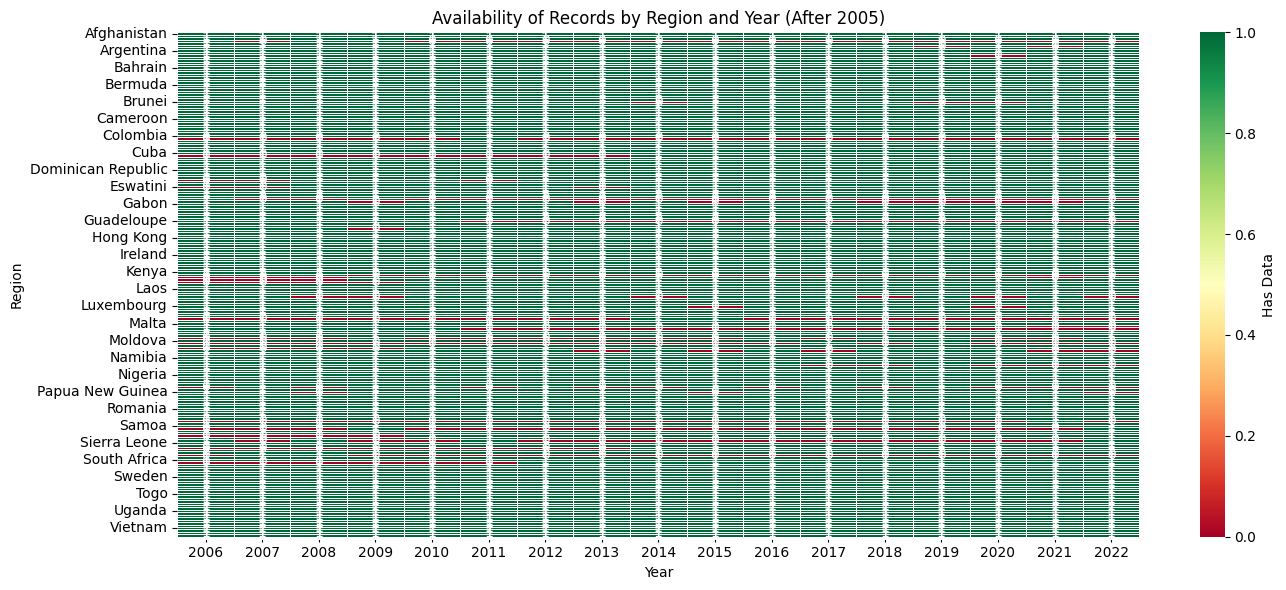

In [13]:
# Plot heatmap of data availability
plt.figure(figsize=(14, 6))
sns.heatmap(
    availability_table,
    cmap="RdYlGn",
    cbar_kws={'label': 'Has Data'},
    linewidths=0.5,
    vmin=0, vmax=1,
    annot=True, fmt='d'
)

plt.title('Availability of Records by Region and Year (After 2005)')
plt.xlabel('Year')
plt.ylabel('Region')
plt.tight_layout()
plt.show()

### After analyzing our dataset, we found that some countries appear only in certain years rather than across the full 18-year period (2005-2022). To ensure our trend analysis is reliable, we'll focus only on countries that have data for all years. This will give us a consistent foundation for spotting genuine patterns and making better forecasts, rather than dealing with gaps that could skew our results.

## 🏷️ Step 10: Identify Common Countries Across All Years

We identify countries that have data for all years, or are missing data in at most two years out of the full range.

In [14]:
# Identify the years in the dataset
years = sorted(df['Year'].unique())
num_years = len(years)

# Get countries present in each year
countries_by_year = {}
for year in years:
    countries_by_year[year] = set(df[df['Year'] == year]['Region'].unique())

# Count the number of years each country appears in
from collections import Counter

country_year_counts = Counter()
for year_set in countries_by_year.values():
    for country in year_set:
        country_year_counts[country] += 1

# Keep countries that appear in all years OR missing only up to 2 years
common_countries = [country for country, count in country_year_counts.items() if count >= num_years - 2]

# Filter the dataset to include only those countries
df_common = df[df['Region'].isin(common_countries)]
print(f"\nFiltered dataset has {len(df_common)} rows (down from {len(df)} rows)")



Filtered dataset has 81027 rows (down from 87507 rows)


## 💾 Save Filtered Dataset

Save this new filtered dataset (with consistent countries only) for trend forecasting.

In [15]:
output_path = "C:/Users/layas/OneDrive/Desktop/Layashree documents/NEU Cources/Intro to Programming in DS/output merged file/common_countries_dataset.xlsx"
df_common.to_excel(output_path, index=False)
print(f"Filtered dataset saved to {output_path}")


Filtered dataset saved to C:/Users/layas/OneDrive/Desktop/Layashree documents/NEU Cources/Intro to Programming in DS/output merged file/common_countries_dataset.xlsx


## 🌐 Step 11: Display Consistently Available Countries

Identify countries with data available for all or almost all (i.e., missing at most 2) of the 18 
years.

In [157]:
def display_countries_grid(countries, columns=6):
    """Display countries in a grid format with specified number of columns"""
    sorted_countries = sorted(countries)
    rows = math.ceil(len(sorted_countries) / columns)
    
    # Create a grid layout
    grid = []
    for i in range(rows):
        row = []
        for j in range(columns):
            idx = i + j * rows
            if idx < len(sorted_countries):
                row.append(sorted_countries[idx])
            else:
                row.append("")
        grid.append(row)
    
    # Print the grid
    print(f"\nNumber of countries present in all years or missing at most two years: {len(sorted_countries)}")
    print("Selected countries:")
    
    # Align the columns
    max_widths = [max(len(grid[i][j]) for i in range(rows) if j < len(grid[i]) and grid[i][j]) for j in range(columns)]
    
    for row in grid:
        line = "  ".join(country.ljust(max_widths[i]) for i, country in enumerate(row) if country)
        print(line)

display_countries_grid(common_countries, columns=8)



Number of countries present in all years or missing at most two years: 177
Selected countries:
Afghanistan          Bosnia and Herzegovina      Cuba                Guatemala      Laos              Netherlands                       Saudi Arabia           Trinidad and Tobago     
Albania              Botswana                    Cyprus              Guinea         Latvia            New Zealand                       Senegal                Tunisia                 
Algeria              Brazil                      Czech Republic      Guinea-Bissau  Lebanon           Nicaragua                         Serbia and Montenegro  Turkey                  
Angola               British Virgin Islands      Denmark             Guyana         Liberia           Niger                             Sierra Leone           Turkmenistan            
Anguilla             Bulgaria                    Djibouti            Haiti          Libya             Nigeria                           Singapore              Turks and

### We've identified 177 countries that have data consistently available throughout the entire 18-year period.

## 🚫 Step 12: Display Incomplete Countries

Some countries are missing data for more than 2 years — these are filtered out from main forecasting.

In [16]:
non_common_countries = set(df['Region'].unique()) - set(common_countries)

def display_countries_grid(countries, columns=5):
    """Display countries in a grid format with specified number of columns"""
    sorted_countries = sorted(countries)
    rows = math.ceil(len(sorted_countries) / columns)
    
    # Create a grid layout
    grid = []
    for i in range(rows):
        row = []
        for j in range(columns):
            idx = i + j * rows
            if idx < len(sorted_countries):
                row.append(sorted_countries[idx])
            else:
                row.append("")
        grid.append(row)
    
    print(f"\nNon-common countries (missing more than two years): {len(sorted_countries)}")
    
    max_widths = [max(len(grid[i][j]) for i in range(rows) if j < len(grid[i]) and grid[i][j]) for j in range(columns)]
    
    for row in grid:
        line = "  ".join(country.ljust(max_widths[i]) for i, country in enumerate(row) if country)
        print(line)

display_countries_grid(non_common_countries, columns=5)



Non-common countries (missing more than two years): 30
American Samoa     French Guiana     Kosovo                        Montenegro             Sao Tome and Principe
Brunei             French Polynesia  Lesotho                       Montserrat             Serbia               
Comoros            Guadeloupe        Maldives                      Netherlands Antilles   Seychelles           
Curacao            Korea             Martinique                    Palau                  Sint Maarten         
Equatorial Guinea  Korea, North      Micronesia, Federated States  Papua New Guinea       Solomon Islands      
Eswatini           Korea, South      Monaco                        Saint Martin (French)  South Sudan          


## 🔍 Step 13: Check Available Years for Specific Country

Use this utility to check how many years of data are available for any specific country:

In [18]:
def search_country_years(df, search_term, plot=False):
    """
    Search for a country by name and display the years of data available.
    Optionally plot a bar chart for visual confirmation.
    
    Parameters:
        df (DataFrame): The main dataset
        search_term (str): Country name or partial match
        plot (bool): If True, displays a bar chart of available years
    """
    matched = df[df['Region'].str.contains(search_term, case=False, na=False)]

    if matched.empty:
        print(f"❌ No data found for '{search_term}'")
        return

    years = sorted(matched['Year'].unique())
    print(f"✅ Data available for '{search_term}' in the following years:")
    print("→ " + ", ".join(map(str, years)))
    print(f"\n📊 Total Years: {len(years)}")

    if plot:
        plt.figure(figsize=(10, 2))
        sns.set_style("whitegrid")
        sns.barplot(x=years, y=[1]*len(years), palette="crest")
        plt.yticks([])
        plt.xlabel("Year")
        plt.title(f"Years of Available Data for '{search_term.title()}'")
        plt.show()


### Example usage

In [19]:
search_country_years(df, 'Cambodia')

✅ Data available for 'Cambodia' in the following years:
→ 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022

📊 Total Years: 17


# Exploratory Data Analysis (EDA)

In [20]:
df_common.head()

,Total,Male,Female,Unknown,Year,Region,Group,Subgroup
0,4321.0,2193.0,2128.0,0.0,2014,Jamaica,Age,Under 18 years
1,2638.0,1324.0,1314.0,0.0,2014,Jamaica,Age,18 to 24 years
2,3517.0,1748.0,1769.0,0.0,2014,Jamaica,Age,25 to 34 years
3,3507.0,1529.0,1978.0,0.0,2014,Jamaica,Age,35 to 44 years
4,2887.0,1053.0,1834.0,0.0,2014,Jamaica,Age,45 to 54 years


In [21]:
occupation_years = df_common[df_common['Group'] == 'Occupation'].groupby('Subgroup')['Year'].unique()
print(occupation_years)



Subgroup
Construction, extraction, maintenance and repair occupations    [2014, 2013, 2012, 2011, 2010, 2009, 2008, 200...
Farming, fishing, and forestry occupations                      [2014, 2013, 2012, 2011, 2010, 2009, 2008, 200...
Homemakers                                                      [2014, 2013, 2012, 2011, 2010, 2009, 2008, 200...
Management, professional, and related occupations               [2014, 2013, 2012, 2011, 2010, 2009, 2008, 200...
Military                                                        [2014, 2013, 2012, 2011, 2010, 2009, 2008, 200...
No occupation/not working outside home                          [2014, 2013, 2012, 2011, 2010, 2009, 2008, 200...
Production, transportation, and material moving occupations     [2014, 2013, 2012, 2011, 2010, 2009, 2008, 200...
Retirees                                                        [2014, 2013, 2012, 2011, 2010, 2009, 2008, 200...
Sales and office occupations                                    [2014, 2013, 20

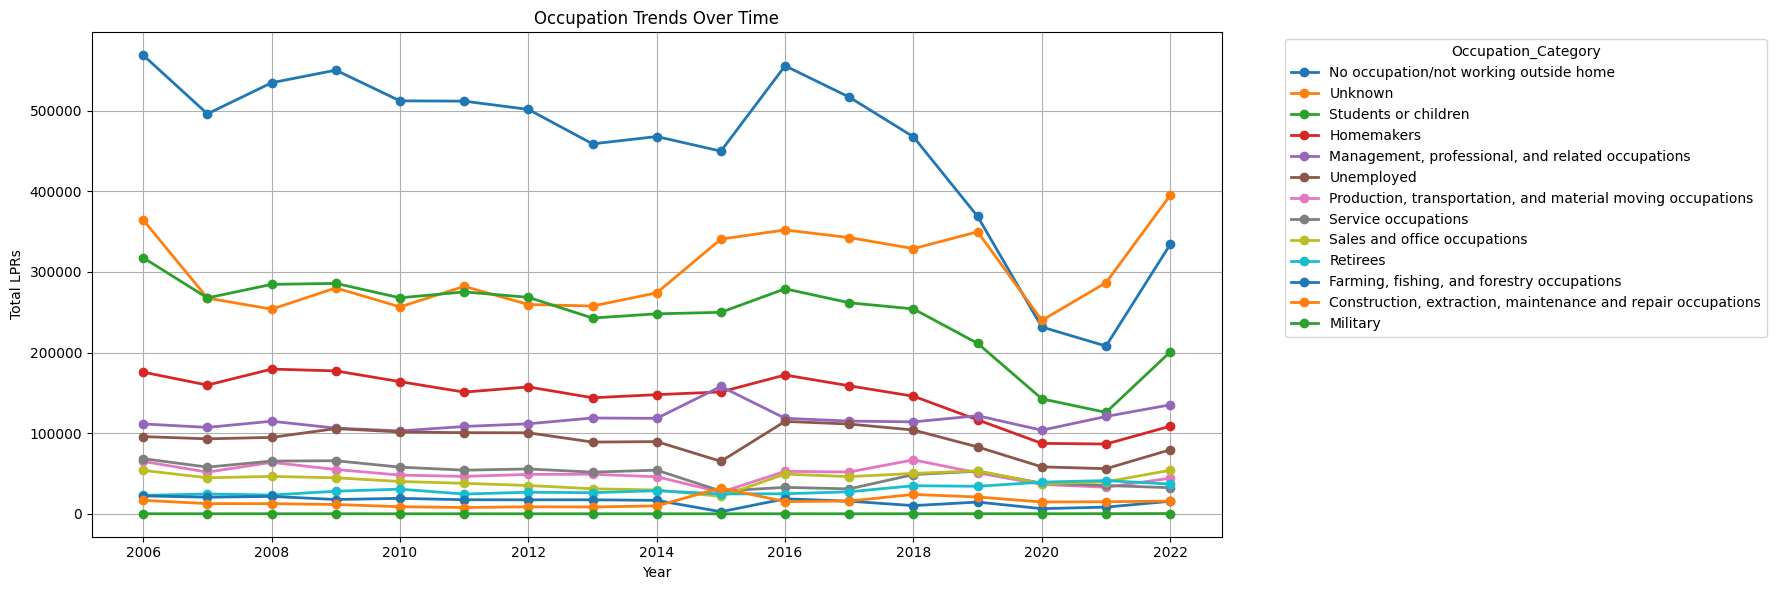

In [22]:
# Step 1: Filter to occupation-only rows
occupation_df = df_common[df_common['Group'] == 'Occupation'].copy()

# Step 2: Assign clean labels
occupation_df['Occupation_Category'] = occupation_df['Subgroup'].str.strip()

# Step 3: Pivot for time-series analysis
trend_df = occupation_df.pivot_table(
    index='Year',
    columns='Occupation_Category',
    values='Total',
    aggfunc='sum'
).fillna(0)

top_5 = trend_df.sum().sort_values(ascending=False).index
trend_df[top_5].plot(figsize=(18, 6), lw=2, marker='o')

plt.title('Occupation Trends Over Time')
plt.ylabel('Total LPRs')
plt.grid()
plt.legend(title="Occupation_Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### From the above graph we want to focus only on occupations for our project purposes. We'll exclude 'Unknown', 'No occupation/not working outside', 'Homemakers', 'Unemployed' and 'Retirees' categories to concentrate on actual employment trends.

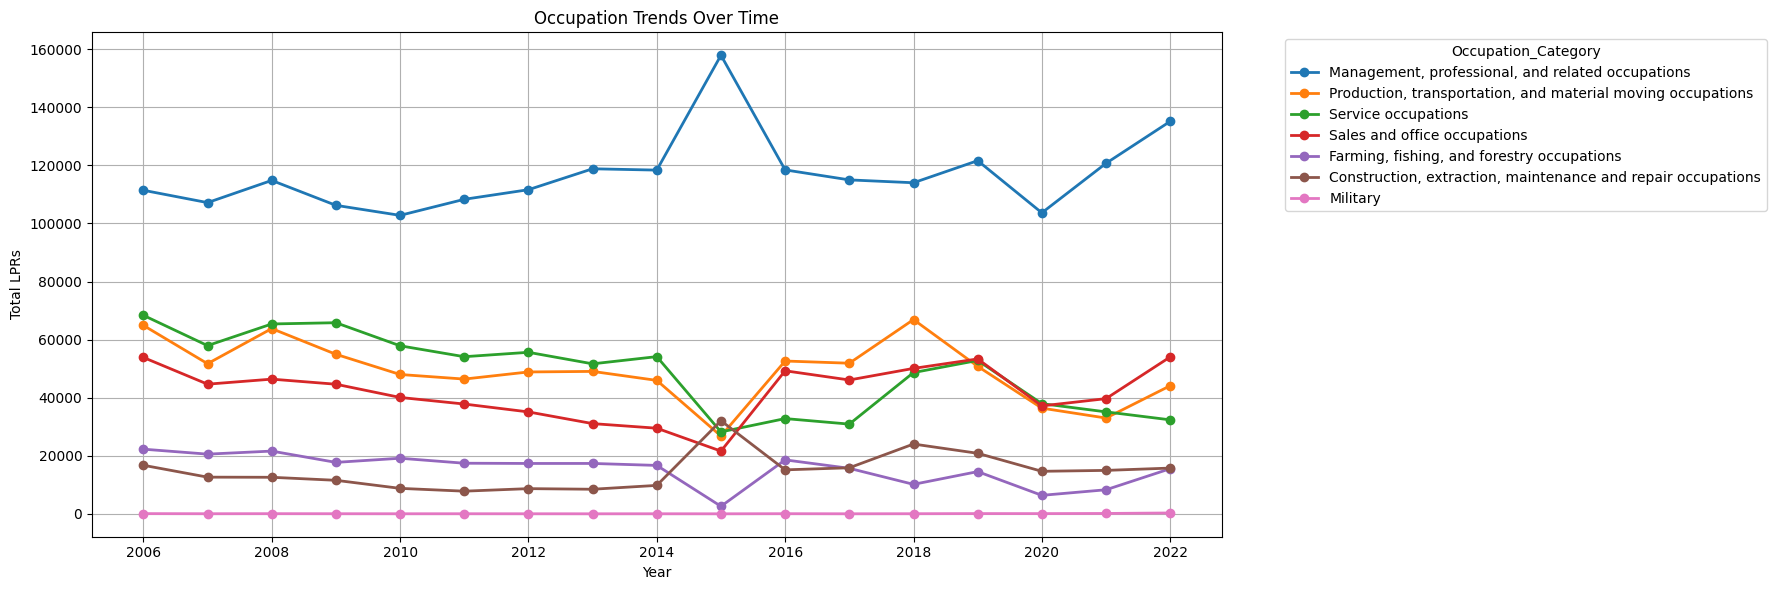

In [ ]:
selected_categories = [
    'Management, professional, and related occupations',
    'Construction, extraction, maintenance and repair occupations', 
    'Farming, fishing, and forestry occupations', 
    'Military', 
    'Production, transportation, and material moving occupations', 
    'Sales and office occupations',
    'Service occupations'
]
occupation_df = occupation_df[occupation_df['Occupation_Category'].isin(selected_categories)]

# Step 3: Pivot for time-series analysis
trend_df = occupation_df.pivot_table(
    index='Year',
    columns='Occupation_Category',
    values='Total',
    aggfunc='sum'
).fillna(0)

top_5 = trend_df.sum().sort_values(ascending=False).index
trend_df[top_5].plot(figsize=(18, 6), lw=2, marker='o')

plt.title('Occupation Trends Over Time')
plt.ylabel('Total LPRs')
plt.grid()
plt.legend(title="Occupation_Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



### We'll also perform a detailed trend analysis for each occupation category individually, examining how they've evolved over the 18-year period. This will help us identify specific growth patterns, cyclical trends, and potential future directions for each occupation type.

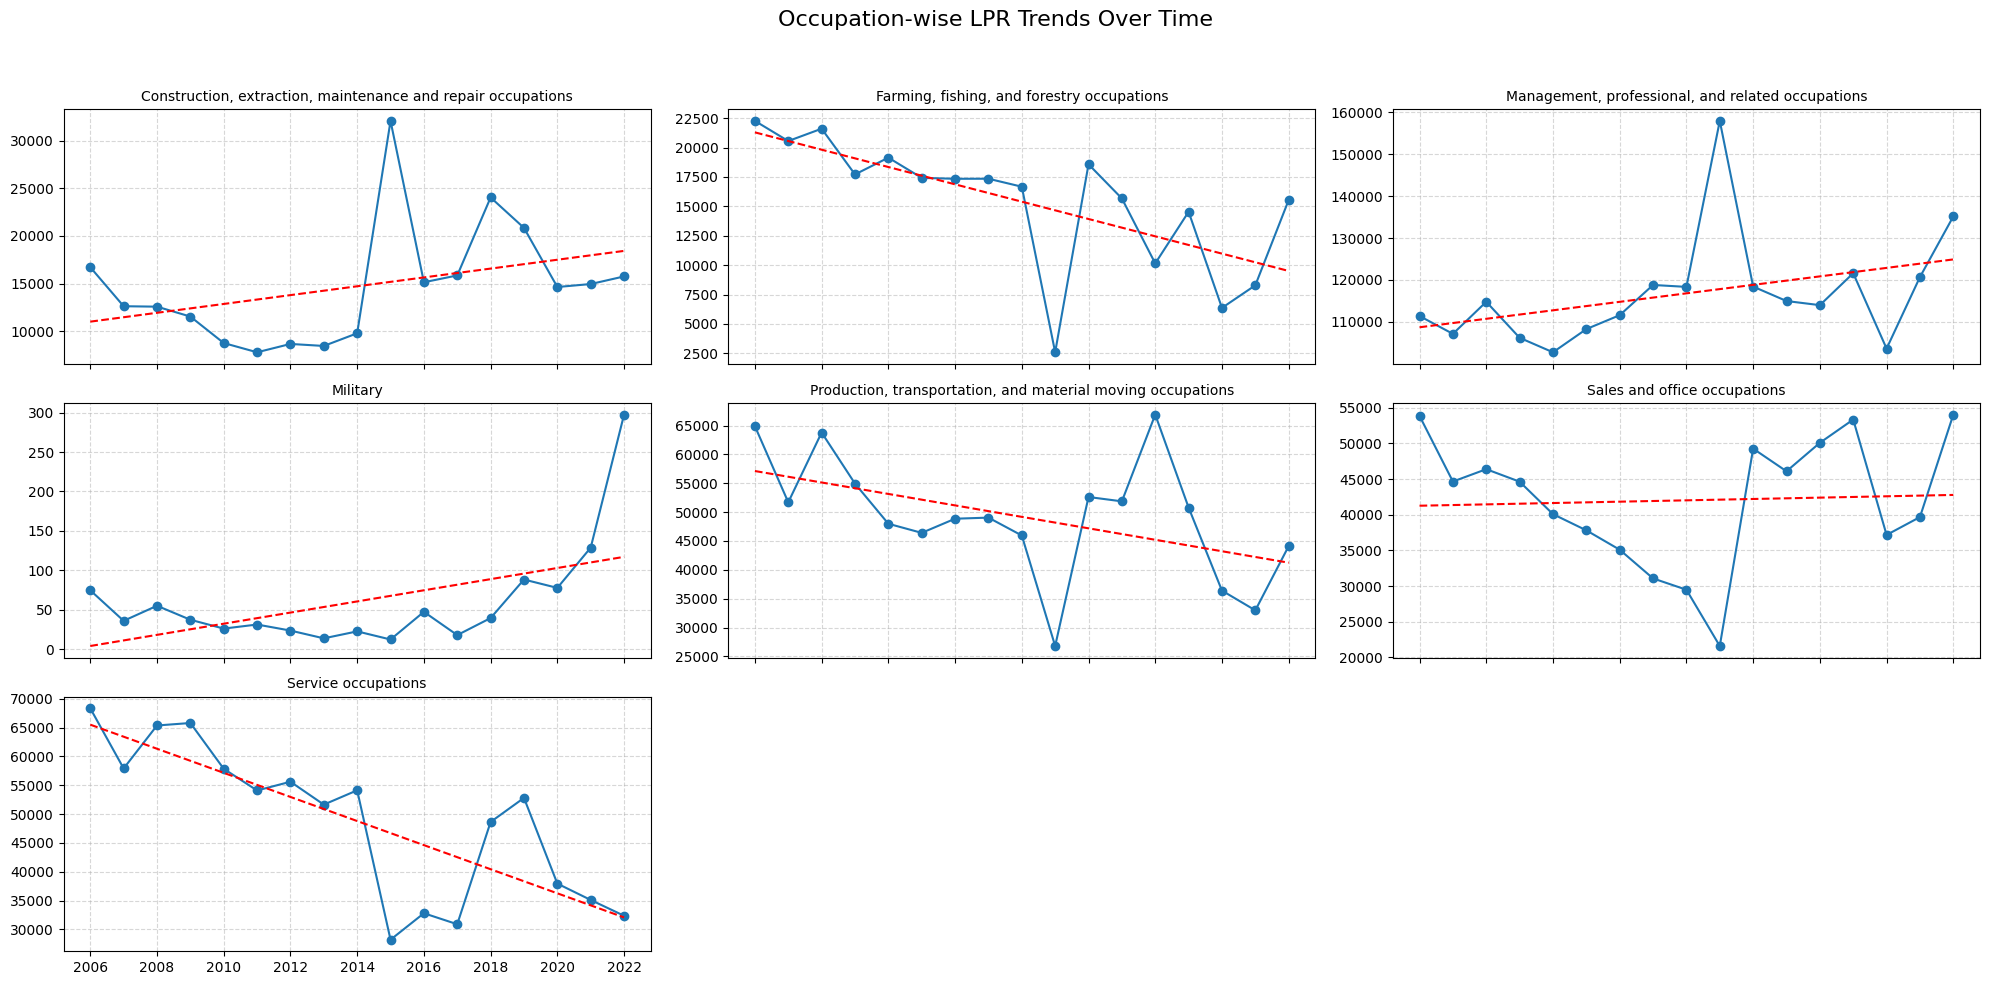

In [24]:

# Pivot data
trend_df = occupation_df.pivot_table(
    index='Year',
    columns='Occupation_Category',
    values='Total',
    aggfunc='sum'
).fillna(0)

# Setup subplots
num_categories = len(trend_df.columns)
cols = 3  # Number of columns in grid
rows = (num_categories + cols - 1) // cols  # Auto-calculate rows

fig, axes = plt.subplots(rows, cols, figsize=(20, 10), sharex=True)
axes = axes.flatten()  # Flatten 2D array of axes

# Plot each occupation in its subplot
for idx, category in enumerate(trend_df.columns):
    ax = axes[idx]
    x = trend_df.index.values
    y = trend_df[category].values

    # Line plot
    ax.plot(x, y, marker='o', label='Data')

    # Trend line
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    ax.plot(x, p(x), linestyle='--', color='red', label='Trend')

    ax.set_title(category, fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.5)

# Hide any unused subplots
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])


# Overall labels and layout
fig.suptitle('Occupation-wise LPR Trends Over Time', fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle

plt.show()


# What These Occupation Trends Tell Us (2006-2022)

## Looking at the Patterns

- **Management & Professional Jobs** are clearly on the rise. After some ups and downs, they're showing strong growth recently. That big spike in 2016 is interesting - might be when some immigration policies changed.

- **Farming & Forestry Work** has a slight upward trend, but bounces up and down quite a bit, probably following seasonal needs or changes in farm policies.

- **Construction Jobs** seem to be slowly decreasing over time, even with occasional jumps. This might reflect less demand for these workers or tougher immigration rules.

- **Service Jobs** show the biggest drop of all, falling by about half from 2006 to 2022. This is a major shift in who's coming to work in restaurants, hotels, and similar places.

- **Military** numbers jump all over the place - some years high, others low. This probably changes based on recruitment needs and where troops are stationed.

- **Production & Transportation** is gradually declining with some big dips and jumps, especially that dramatic drop in 2016.

- **Sales & Office Work** stays fairly steady compared to the others, suggesting these jobs remain consistently available to immigrants.

## What This Means

The wild swings we see in almost all job categories suggest outside events - like economic changes, new laws, or world events - have big effects on immigration patterns.

For our forecasting, the years after 2016 might give us better clues about future trends since the patterns look a bit more settled than the earlier years.

# 📊 Age vs Occupation Correlation Analysis Heatmap

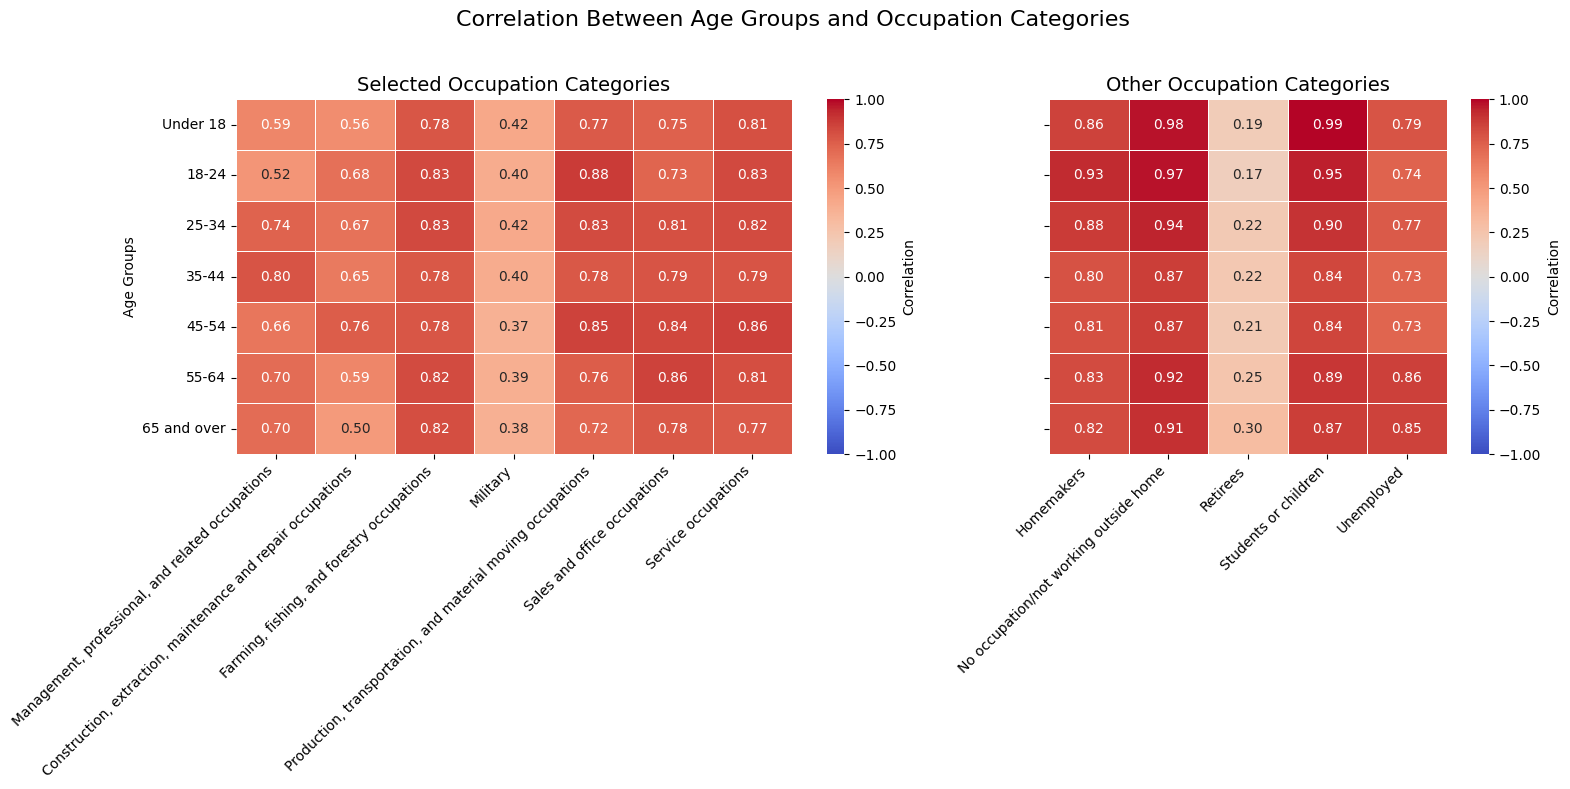

In [25]:
age_df = df_common[df_common['Group'] == 'Age'].copy()
occupation_df = df_common[df_common['Group'] == 'Occupation'].copy()

def standardize_age(age):
    age = str(age)
    if 'Under 18' in age:
        return 'Under 18'
    elif '18' in age and '24' in age:
        return '18-24'
    elif '25' in age and '34' in age:
        return '25-34'
    elif '35' in age and '44' in age:
        return '35-44'
    elif '45' in age and '54' in age:
        return '45-54'
    elif '55' in age and '64' in age:
        return '55-64'
    elif '65' in age:
        return '65 and over'
    else:
        return None

age_df['Age_Group'] = age_df['Subgroup'].apply(standardize_age)
occupation_df['Occupation_Category'] = occupation_df['Subgroup'].str.strip()

age_grouped = age_df.groupby(['Year', 'Region', 'Age_Group'])['Total'].sum().unstack().fillna(0)
occupation_grouped = occupation_df.groupby(['Year', 'Region', 'Occupation_Category'])['Total'].sum().unstack().fillna(0)

merged = age_grouped.merge(occupation_grouped, on=['Year', 'Region'], how='inner', suffixes=('_Age', '_Occupation'))

# Filter for selected categories (must exist in the data)
available_categories = [cat for cat in selected_categories if cat in occupation_grouped.columns]
other_categories = [cat for cat in occupation_grouped.columns if cat not in selected_categories and cat != 'Unknown']

correlation_selected = merged.corr().loc[age_grouped.columns, available_categories]
correlation_others = merged.corr().loc[age_grouped.columns, other_categories]

ordered_age_groups = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65 and over']
correlation_selected = correlation_selected.loc[ordered_age_groups]
correlation_others = correlation_others.loc[ordered_age_groups]

fig_width = min(22, max(16, (len(available_categories) + len(other_categories)) * 0.8))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(fig_width, 8), 
                              gridspec_kw={'width_ratios': [len(available_categories), len(other_categories)]})

# Plot first heatmap (selected categories)
sns.heatmap(correlation_selected, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, 
            vmin=-1, vmax=1, center=0, ax=ax1, cbar_kws={'label': 'Correlation'})
ax1.set_title('Selected Occupation Categories', fontsize=14)
ax1.set_xlabel('')
ax1.set_ylabel('Age Groups')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0)

# Plot second heatmap (other categories)
sns.heatmap(correlation_others, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, 
            vmin=-1, vmax=1, center=0, ax=ax2, cbar_kws={'label': 'Correlation'})
ax2.set_title('Other Occupation Categories', fontsize=14)
ax2.set_xlabel('')
ax2.set_ylabel('')  # No y-label for the second subplot
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
ax2.set_yticklabels([])  # Hide y-tick labels for the second subplot

plt.suptitle('Correlation Between Age Groups and Occupation Categories', fontsize=16, y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# How Age and Jobs Connect for Immigrants

This heat map shows us which age groups tend to go into which jobs when people immigrate. The darker the red, the stronger the connection.

## What Jumps Out

- **Young Adults (18-24)** have the strongest connection to production and transportation jobs (0.89) and service jobs (0.84). This makes sense since these are often entry-level positions that don't require lots of experience.

- **Mid-Career Adults (35-44)** show the strongest link to management and professional jobs (0.80), likely because these roles typically need more experience and education.

- **Military** has the weakest connections across all age groups (mostly around 0.50), suggesting military immigration follows different patterns than other job sectors.

- **Production/Transportation Jobs** have strong connections with all age groups but especially with younger adults, showing these are accessible across age ranges.

- **Service Jobs** connect strongly with every age group, but especially with middle-aged adults (45-54), with a correlation of 0.87.

## The Other Categories

The right side shows non-work categories, where we see extremely high correlations like:
- "Students or children" with "Under 18" (0.99) - obviously these go together
- "Not working outside home" with all age groups (0.87-0.98)

These strong correlations on the right help confirm our analysis is working properly, as these relationships make logical sense.

The patterns suggest that age plays a significant role in what jobs immigrants take, with certain occupations being more accessible or appealing to specific age groups.

# 📊 Age vs Admission_Category Correlation Analysis Heatmap

All admission categories: ['Diversity', 'Employment-based preferences', 'Family-sponsored preferences', 'Immediate relatives of U.S. citizens', 'Other', 'Refugees and asylees']


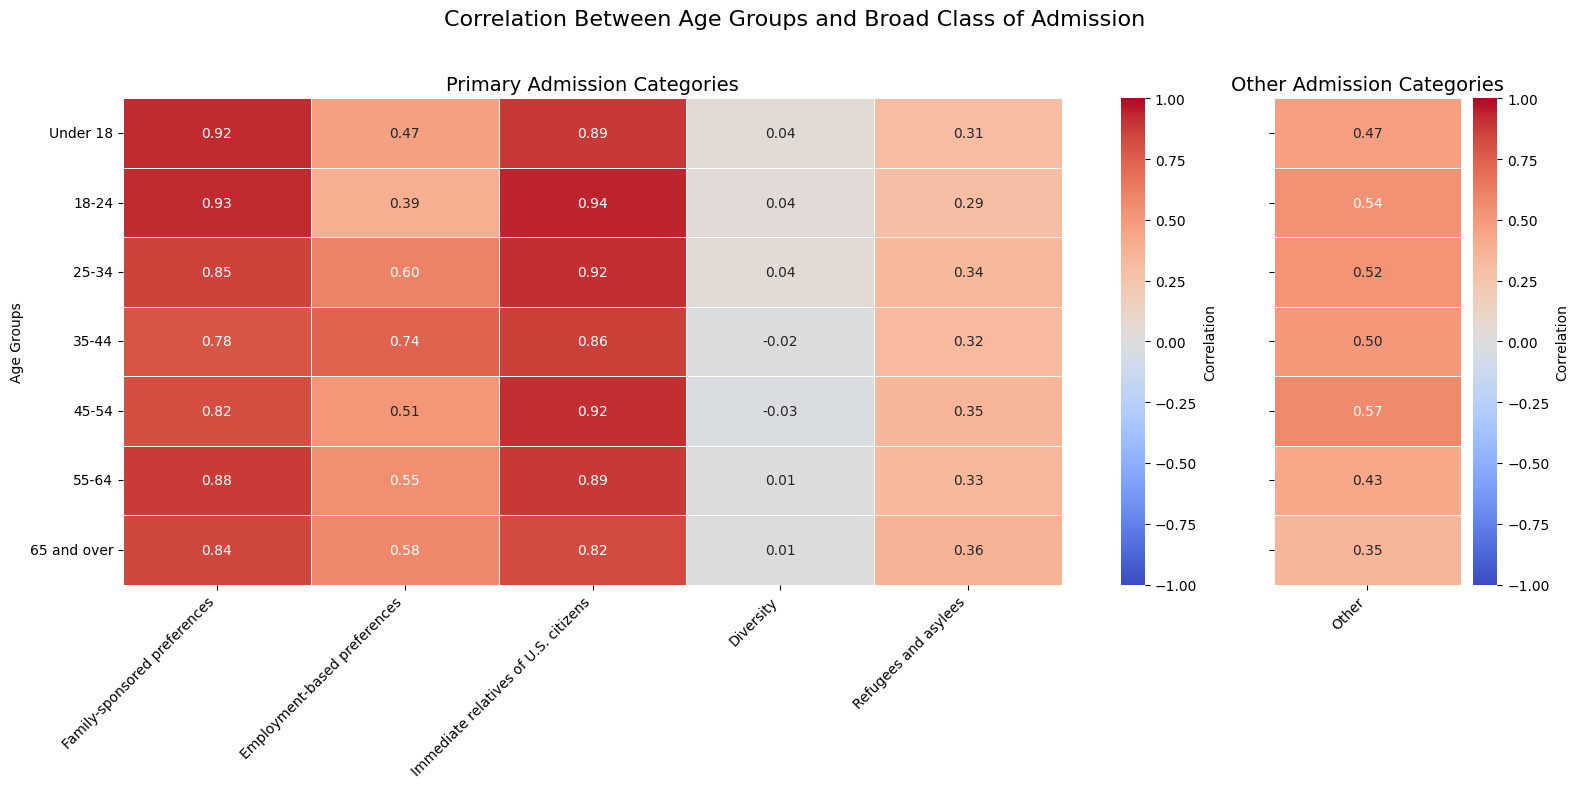

In [26]:
age_df = df_common[df_common['Group'] == 'Age'].copy()
admission_df = df_common[df_common['Group'] == 'Broad Class of Admission'].copy()

# Step 2: Standardize age groups
def standardize_age(age):
    age = str(age)
    if 'Under 18' in age:
        return 'Under 18'
    elif '18' in age and '24' in age:
        return '18-24'
    elif '25' in age and '34' in age:
        return '25-34'
    elif '35' in age and '44' in age:
        return '35-44'
    elif '45' in age and '54' in age:
        return '45-54'
    elif '55' in age and '64' in age:
        return '55-64'
    elif '65' in age:
        return '65 and over'
    else:
        return None

age_df['Age_Group'] = age_df['Subgroup'].apply(standardize_age)
admission_df['Admission_Category'] = admission_df['Subgroup'].str.strip()

# Step 3: Group by Year & Region and pivot
age_grouped = age_df.groupby(['Year', 'Region', 'Age_Group'])['Total'].sum().unstack().fillna(0)
admission_grouped = admission_df.groupby(['Year', 'Region', 'Admission_Category'])['Total'].sum().unstack().fillna(0)

# Step 4: Merge on Year & Region
merged = age_grouped.merge(admission_grouped, on=['Year', 'Region'], how='inner', suffixes=('_Age', '_Admission'))

# Step 5: Define selected and other admission categories
# First, get all unique admission categories
all_admission_categories = sorted(admission_df['Admission_Category'].unique())
print(f"All admission categories: {all_admission_categories}")

# Select primary admission categories
selected_categories = [
    'Family-sponsored preferences',
    'Employment-based preferences',
    'Immediate relatives of U.S. citizens',
    'Diversity',
    'Refugees and asylees'
]

# Filter for selected categories (must exist in the data)
available_categories = [cat for cat in selected_categories if cat in admission_grouped.columns]
other_categories = [cat for cat in admission_grouped.columns if cat not in selected_categories and cat != 'Unknown']

# Step 6: Compute correlation for both sets
correlation_selected = merged.corr().loc[age_grouped.columns, available_categories]
correlation_others = merged.corr().loc[age_grouped.columns, other_categories]

# Reorder the age groups for logical presentation
ordered_age_groups = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65 and over']
ordered_age_groups = [age for age in ordered_age_groups if age in correlation_selected.index]
correlation_selected = correlation_selected.loc[ordered_age_groups]
correlation_others = correlation_others.loc[ordered_age_groups]

# Calculate appropriate figure size based on number of categories
fig_width = min(22, max(16, (len(available_categories) + len(other_categories)) * 0.8))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(fig_width, 8), 
                              gridspec_kw={'width_ratios': [len(available_categories), len(other_categories)]})

# Plot first heatmap (selected categories)
sns.heatmap(correlation_selected, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, 
            vmin=-1, vmax=1, center=0, ax=ax1, cbar_kws={'label': 'Correlation'})
ax1.set_title('Primary Admission Categories', fontsize=14)
ax1.set_xlabel('')
ax1.set_ylabel('Age Groups')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0)

# Plot second heatmap (other categories)
sns.heatmap(correlation_others, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, 
            vmin=-1, vmax=1, center=0, ax=ax2, cbar_kws={'label': 'Correlation'})
ax2.set_title('Other Admission Categories', fontsize=14)
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
ax2.set_yticklabels([])
plt.suptitle('Correlation Between Age Groups and Broad Class of Admission', fontsize=16, y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# How Age Relates to Immigration Paths

This heat map reveals the connections between different age groups and how people immigrate to the country. Darker red means a stronger relationship.

## Main Patterns

- **Family Connections Matter**: Family-sponsored immigration shows strong correlations across all age groups (0.78-0.93), particularly for younger people (0.93 for both under 18 and 18-24 age groups).

- **Family Reunification is Key**: The strongest correlations on the entire map are between "Immediate relatives of U.S. citizens" and nearly all age groups, with the 18-24 group showing the highest correlation (0.94). This shows how central family reunification is to our immigration system.

- **Work-Based Immigration**: Employment-based preferences show the strongest connection with ages 35-44 (0.74), which makes sense as these are prime working years when immigrants have developed career skills.

- **Diversity Visa Program**: This shows very weak correlations across all age groups (0.08-0.17), suggesting the diversity lottery brings in a much more random age distribution than other paths.

- **Refugees and Asylees**: This category shows moderate correlations (0.31-0.39) across all age groups, with slightly higher numbers for older adults.

## What This Tells Us

The data clearly shows our immigration system is heavily centered around family connections, with employment paths being particularly important for mid-career adults. The diversity visa program appears to operate quite differently from other immigration paths, showing little connection to specific age groups.

This information helps us understand how different immigration pathways serve different demographic groups, which could be valuable for predicting future immigration patterns based on policy changes.

# 📊 Age vs Admission_Category Correlation Analysis Heatmap

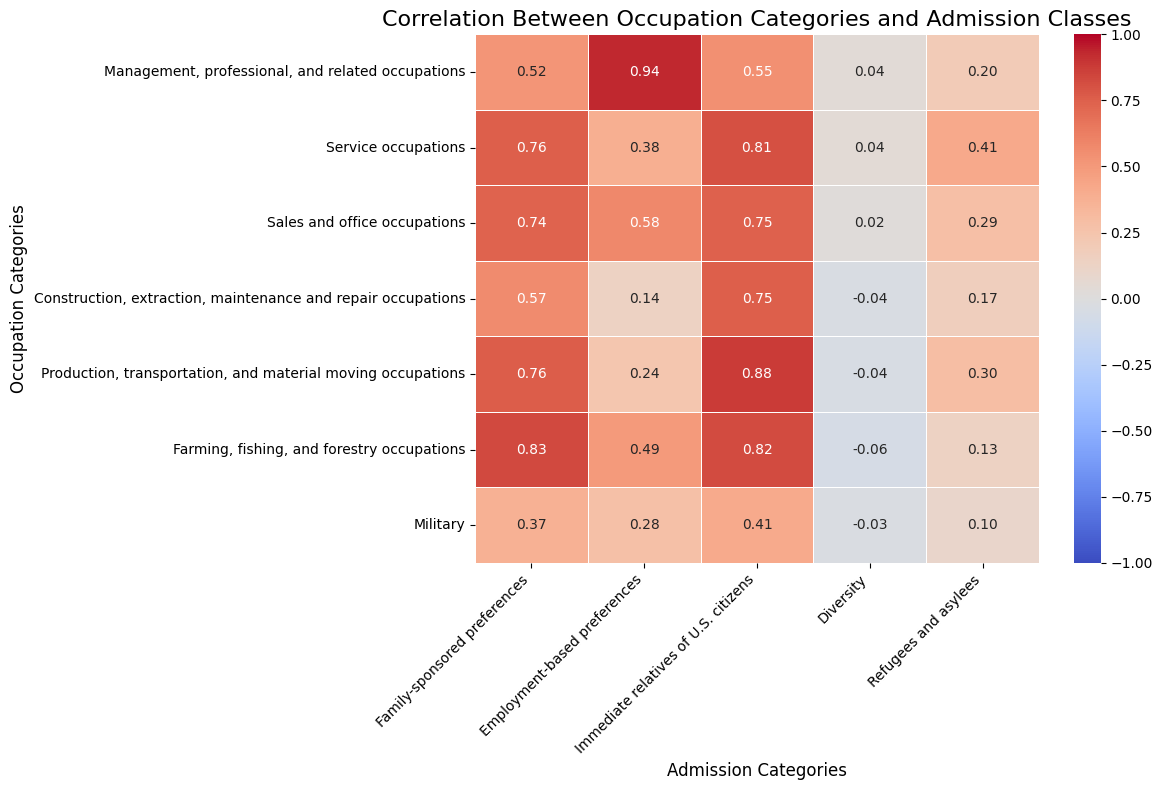

In [27]:
# Occupation vs. Broad Class of Admission Correlation Analysis

# Step 1: Filter the data for Occupation and Broad Class of Admission
occupation_df = df_common[df_common['Group'] == 'Occupation'].copy()
admission_df = df_common[df_common['Group'] == 'Broad Class of Admission'].copy()

# Step 2: Clean category labels
occupation_df['Occupation_Category'] = occupation_df['Subgroup'].str.strip()
admission_df['Admission_Category'] = admission_df['Subgroup'].str.strip()

# Step 3: Group by Year & Region and pivot
occupation_grouped = occupation_df.groupby(['Year', 'Region', 'Occupation_Category'])['Total'].sum().unstack().fillna(0)
admission_grouped = admission_df.groupby(['Year', 'Region', 'Admission_Category'])['Total'].sum().unstack().fillna(0)

# Step 4: Merge on Year & Region
merged = occupation_grouped.merge(admission_grouped, on=['Year', 'Region'], how='inner')

# Step 5: Define key occupation and admission categories
key_occupations = [
    'Management, professional, and related occupations',
    'Service occupations',
    'Sales and office occupations',
    'Construction, extraction, maintenance and repair occupations',
    'Production, transportation, and material moving occupations',
    'Farming, fishing, and forestry occupations',
    'Military'
]

key_admissions = [
    'Family-sponsored preferences',
    'Employment-based preferences',
    'Immediate relatives of U.S. citizens',
    'Diversity',
    'Refugees and asylees'
]

# Filter for categories that exist in the data
available_occupations = [cat for cat in key_occupations if cat in occupation_grouped.columns]
available_admissions = [cat for cat in key_admissions if cat in admission_grouped.columns]

# Step 6: Compute correlations between occupations and admissions
correlation_matrix = merged.corr().loc[available_occupations, available_admissions]

plt.figure(figsize=(12, 8))
sns.heatmap(
    correlation_matrix, 
    annot=True, 
    cmap='coolwarm', 
    fmt=".2f", 
    linewidths=0.5, 
    vmin=-1, 
    vmax=1, 
    center=0
)

plt.title('Correlation Between Occupation Categories and Admission Classes', fontsize=16)
plt.xlabel('Admission Categories', fontsize=12)
plt.ylabel('Occupation Categories', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# How Immigration Pathways Connect to Jobs

This heat map shows us which immigration categories tend to lead to different occupations. The darker red squares show stronger connections.

## Key Patterns

- **Management & Professional Jobs** have an extremely strong link to employment-based preferences (0.94), which makes perfect sense since these visas are often designed for skilled professionals.

- **Production & Transportation Jobs** show the strongest connection with immediate relatives of U.S. citizens (0.88) and family-sponsored preferences (0.77), suggesting these workers often come through family connections rather than work visas.

- **Service Occupations** follow a similar pattern, with strong connections to family categories: immediate relatives (0.81) and family-sponsored preferences (0.76).

- **Sales & Office Work** also connects strongly to family-based immigration, showing correlations of 0.75 with immediate relatives and 0.71 with family-sponsored categories.

- **The Diversity Visa** program shows very weak correlations with all occupation types (all below 0.16), suggesting diversity immigrants spread across various occupations without strong patterns.

- **Military** has moderate correlations across all immigration categories, with none standing out significantly.

## What This Tells Us

The data reveals two main paths into the American workforce:

1. **Skilled professionals** primarily enter through employment-based visas, following a direct path from visa category to occupation.

2. **Service, production, and sales workers** mostly come through family connections, suggesting family networks help immigrants find jobs in these sectors.

This information could help predict how changes to immigration policies might affect different sectors of the workforce, and shows how family-based immigration significantly contributes to multiple sectors of the economy.

# 📈 Step 16: Forecasting Occupation Trends (Polynomial Regression)

We now forecast trends for selected occupations using 2nd-degree polynomial regression.

In [28]:
occupation_data = df[df['Subgroup'] == 'Management, professional, and related occupations']
ts = occupation_data.groupby('Year')['Total'].sum()

C:\Users\layas\AppData\Local\Temp\ipykernel_7560\2354055799.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_common['Year'] = pd.to_datetime(df['Year'], format='%Y')
C:\Users\layas\AppData\Local\Temp\ipykernel_7560\2354055799.py:30: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  ts = pd.Series(yearly.values, index=pd.date_range(
C:\Users\layas\AppData\Local\Temp\ipykernel_7560\2354055799.py:48: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  forecast_index = pd.date_range(start=f'{forecast_years_array[0][0]}-01-01', periods=len(forecast_years_array), freq='AS')


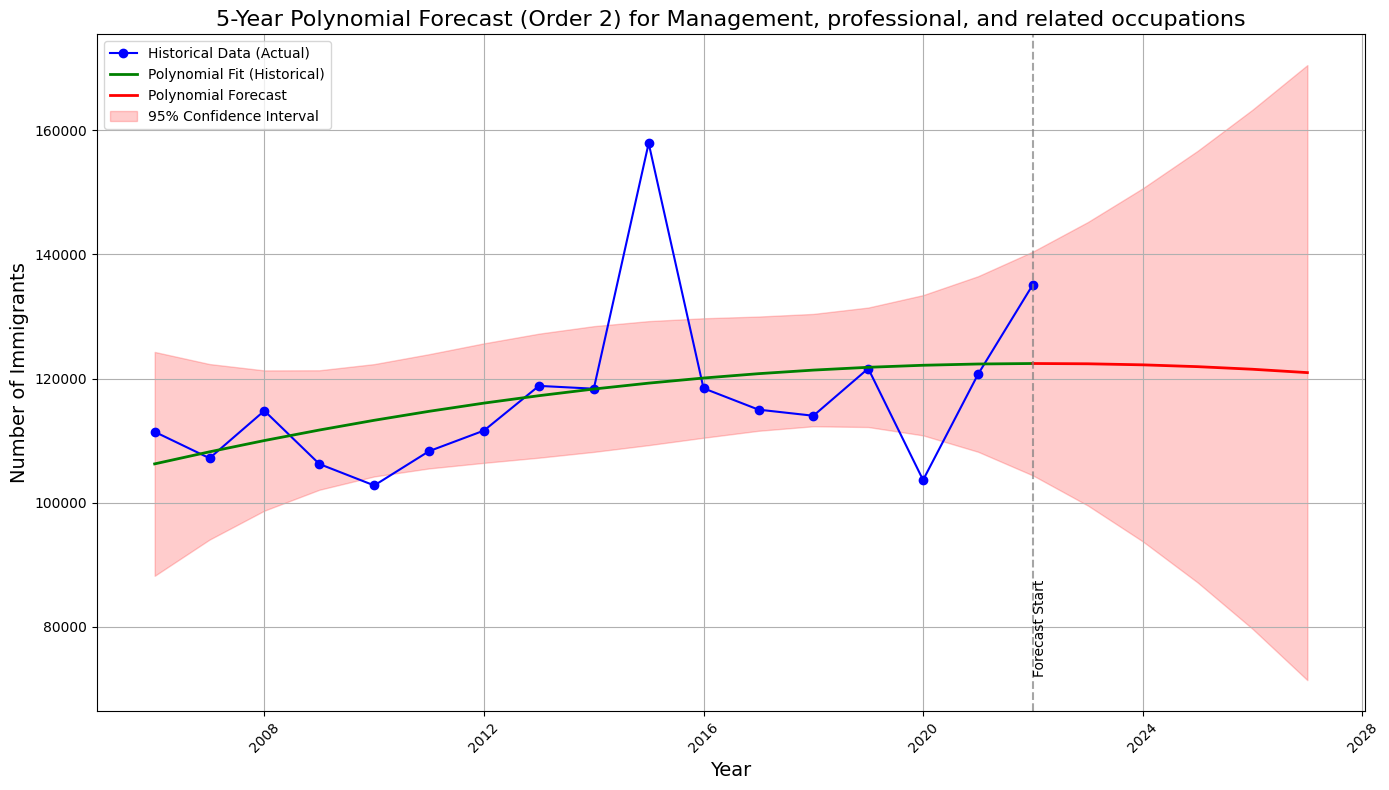

✅ Forecast plotted and saved for: Management, professional, and related occupations | R²: 0.1600


C:\Users\layas\AppData\Local\Temp\ipykernel_7560\2354055799.py:30: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  ts = pd.Series(yearly.values, index=pd.date_range(
C:\Users\layas\AppData\Local\Temp\ipykernel_7560\2354055799.py:48: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  forecast_index = pd.date_range(start=f'{forecast_years_array[0][0]}-01-01', periods=len(forecast_years_array), freq='AS')


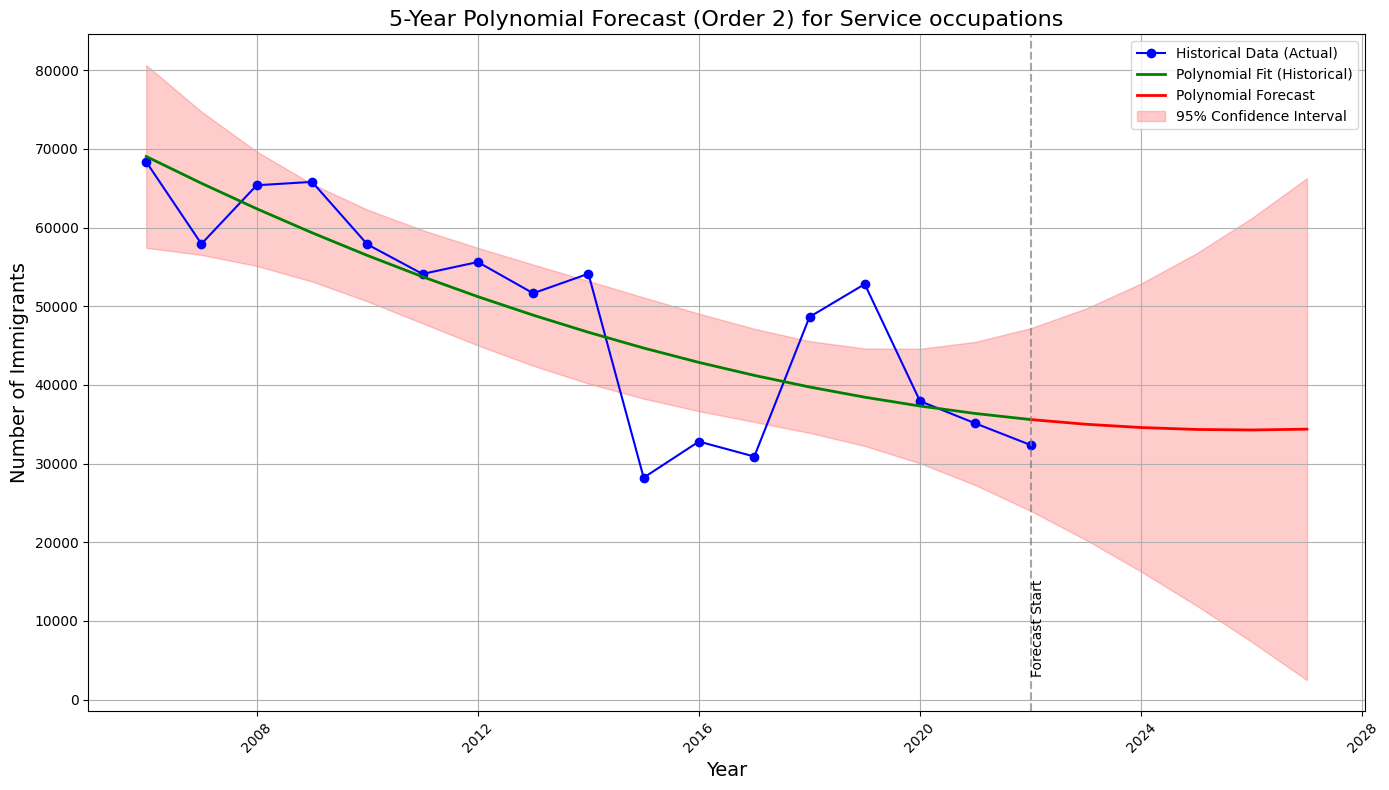

✅ Forecast plotted and saved for: Service occupations | R²: 0.6545


C:\Users\layas\AppData\Local\Temp\ipykernel_7560\2354055799.py:30: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  ts = pd.Series(yearly.values, index=pd.date_range(
C:\Users\layas\AppData\Local\Temp\ipykernel_7560\2354055799.py:48: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  forecast_index = pd.date_range(start=f'{forecast_years_array[0][0]}-01-01', periods=len(forecast_years_array), freq='AS')


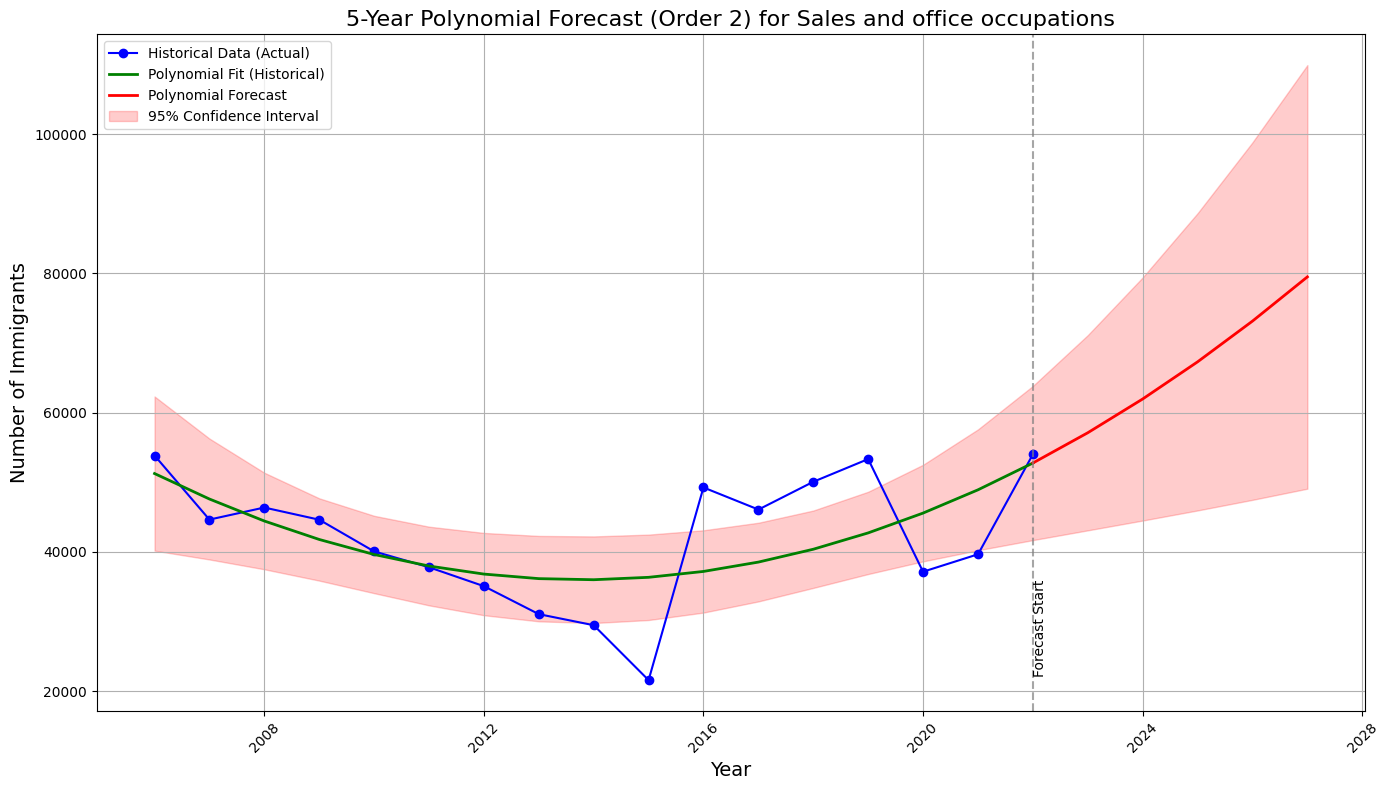

✅ Forecast plotted and saved for: Sales and office occupations | R²: 0.3559


C:\Users\layas\AppData\Local\Temp\ipykernel_7560\2354055799.py:30: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  ts = pd.Series(yearly.values, index=pd.date_range(
C:\Users\layas\AppData\Local\Temp\ipykernel_7560\2354055799.py:48: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  forecast_index = pd.date_range(start=f'{forecast_years_array[0][0]}-01-01', periods=len(forecast_years_array), freq='AS')


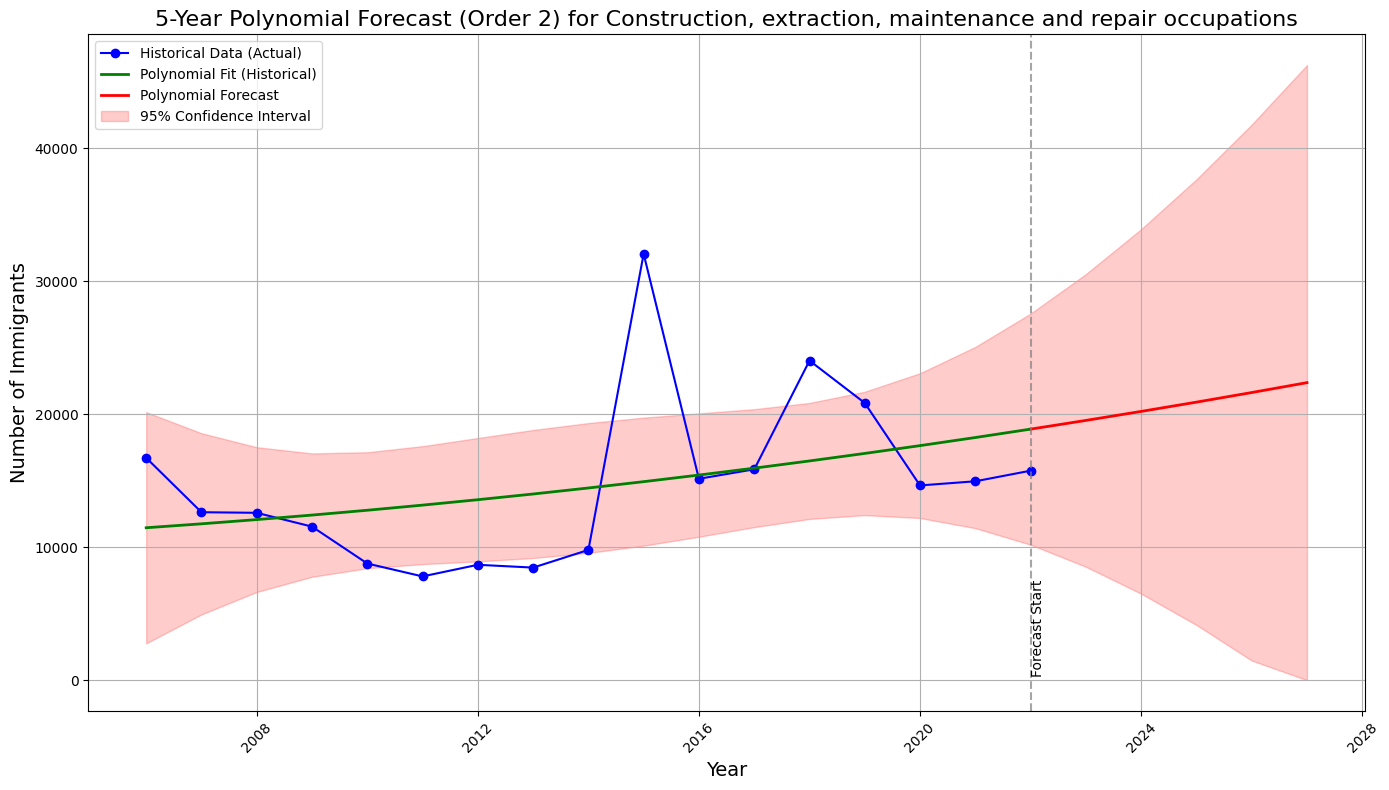

✅ Forecast plotted and saved for: Construction, extraction, maintenance and repair occupations | R²: 0.1399


C:\Users\layas\AppData\Local\Temp\ipykernel_7560\2354055799.py:30: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  ts = pd.Series(yearly.values, index=pd.date_range(
C:\Users\layas\AppData\Local\Temp\ipykernel_7560\2354055799.py:48: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  forecast_index = pd.date_range(start=f'{forecast_years_array[0][0]}-01-01', periods=len(forecast_years_array), freq='AS')


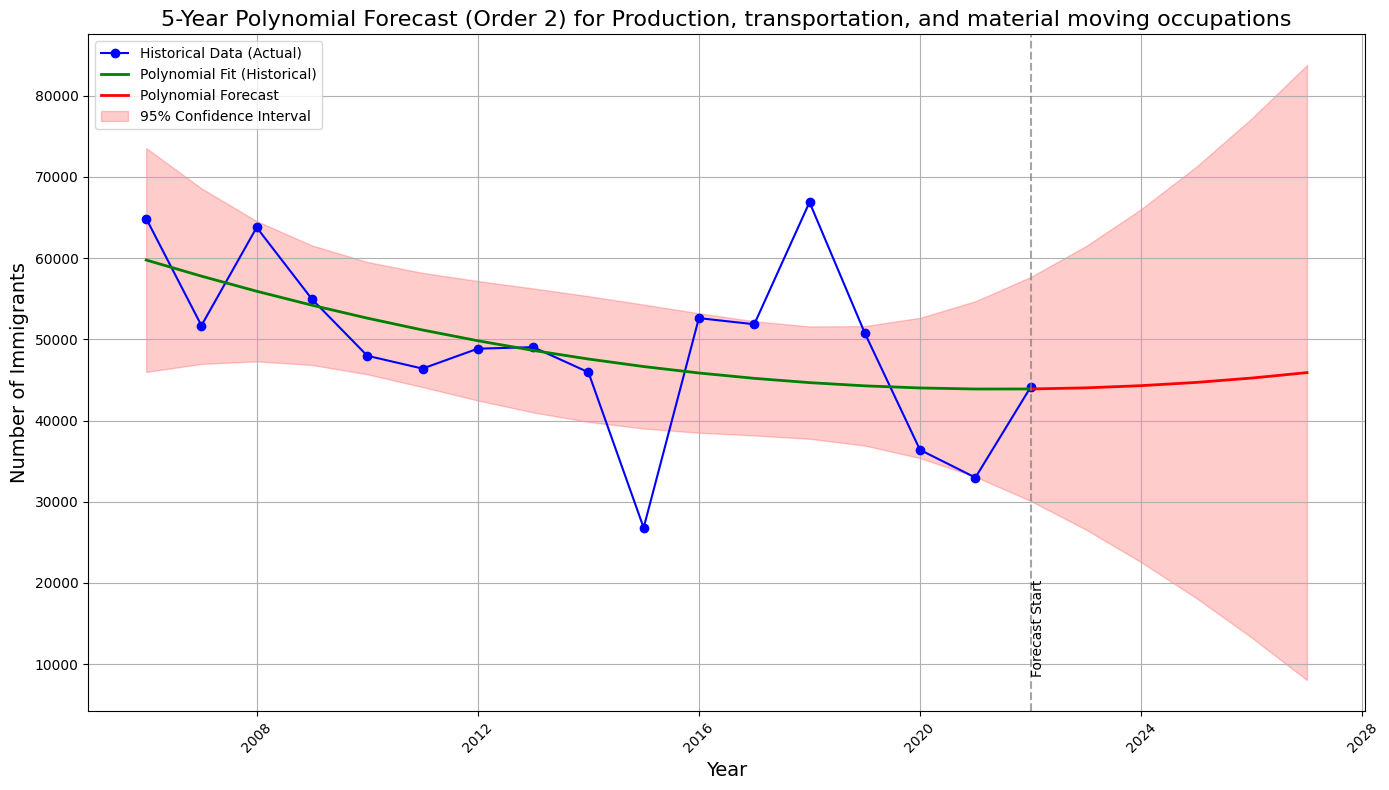

✅ Forecast plotted and saved for: Production, transportation, and material moving occupations | R²: 0.2415


C:\Users\layas\AppData\Local\Temp\ipykernel_7560\2354055799.py:30: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  ts = pd.Series(yearly.values, index=pd.date_range(
C:\Users\layas\AppData\Local\Temp\ipykernel_7560\2354055799.py:48: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  forecast_index = pd.date_range(start=f'{forecast_years_array[0][0]}-01-01', periods=len(forecast_years_array), freq='AS')


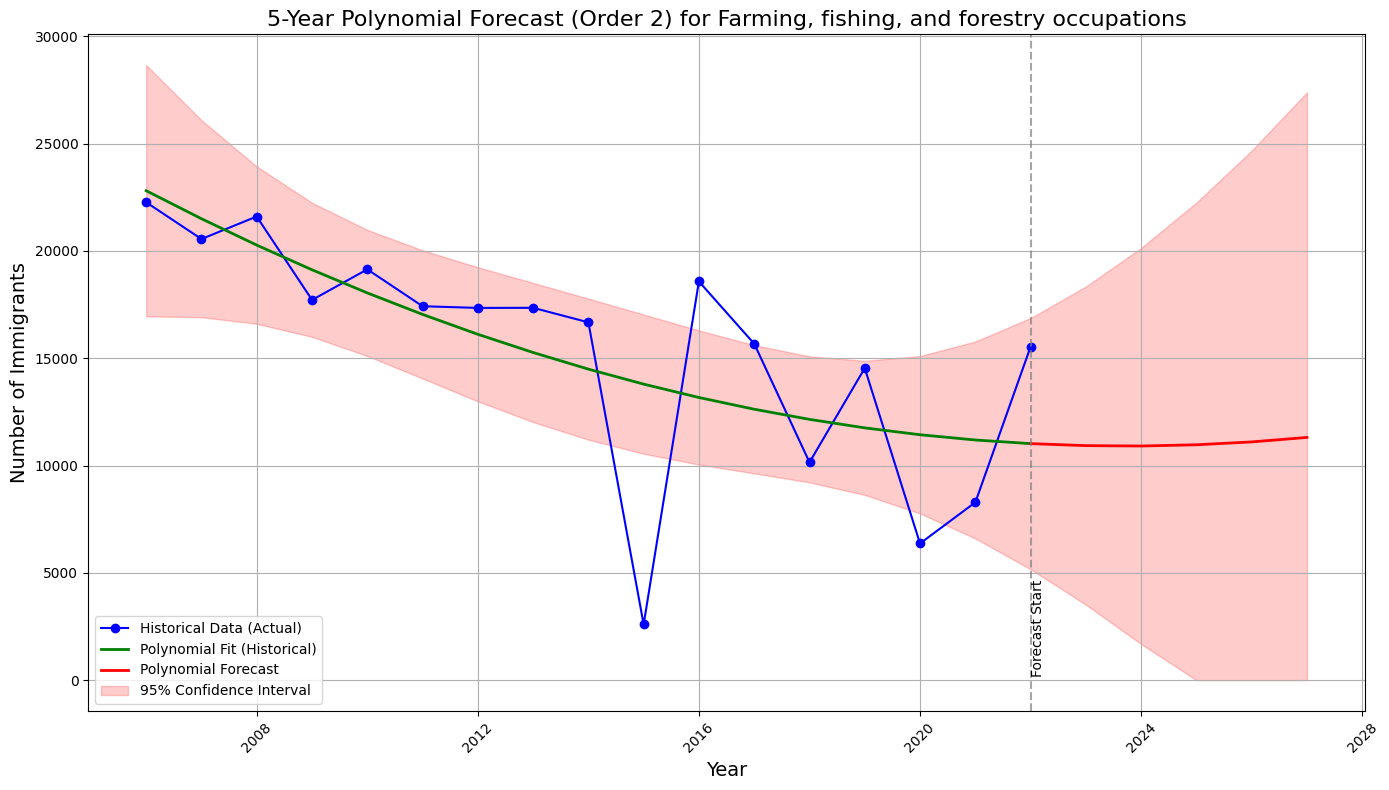

✅ Forecast plotted and saved for: Farming, fishing, and forestry occupations | R²: 0.4846


C:\Users\layas\AppData\Local\Temp\ipykernel_7560\2354055799.py:30: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  ts = pd.Series(yearly.values, index=pd.date_range(
C:\Users\layas\AppData\Local\Temp\ipykernel_7560\2354055799.py:48: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  forecast_index = pd.date_range(start=f'{forecast_years_array[0][0]}-01-01', periods=len(forecast_years_array), freq='AS')


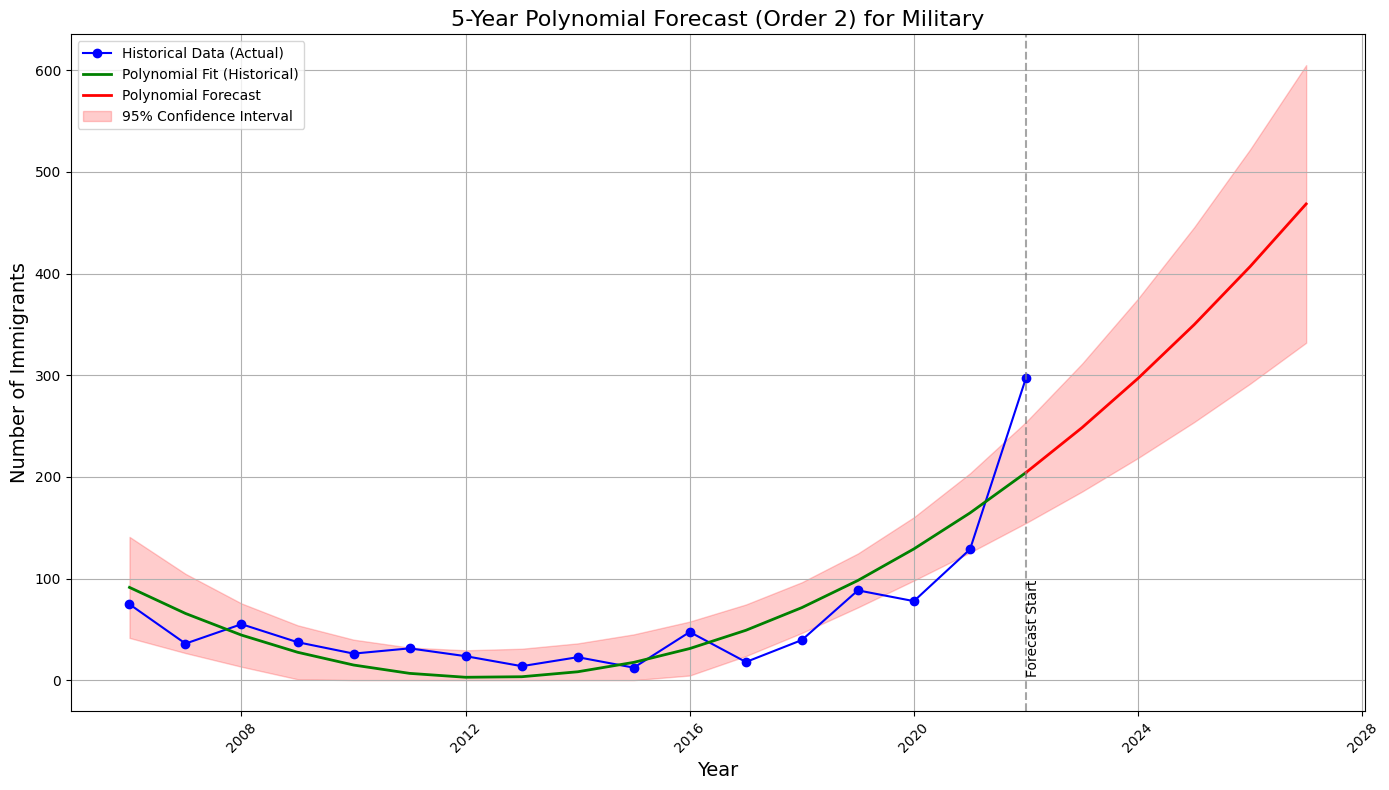

✅ Forecast plotted and saved for: Military | R²: 0.7624


In [31]:
# KEY OCCUPATIONS
key_occupations = [
    'Management, professional, and related occupations',
    'Service occupations',
    'Sales and office occupations',
    'Construction, extraction, maintenance and repair occupations',
    'Production, transportation, and material moving occupations',
    'Farming, fishing, and forestry occupations',
    'Military'
]

# Prepare data
df_common['Year'] = pd.to_datetime(df['Year'], format='%Y')
occupation_data = df_common[df_common['Group'] == 'Occupation'].copy()

# Output folder for plots
os.makedirs("forecast_plots", exist_ok=True)

# Loop through each key occupation
for subgroup in key_occupations:
    try:
        # Filter and group data
        subgroup_data = occupation_data[occupation_data['Subgroup'] == subgroup]
        yearly = subgroup_data.groupby(subgroup_data['Year'].dt.year)['Total'].sum()

        if len(yearly) < 3:
            print(f"⚠️ Skipping {subgroup} - not enough data.")
            continue

        ts = pd.Series(yearly.values, index=pd.date_range(
            start=f'{yearly.index[0]}-01-01',
            periods=len(yearly),
            freq='AS'
        ))

        years_array = np.array([d.year for d in ts.index]).reshape(-1, 1)
        values = ts.values

        # Polynomial Regression (degree 2)
        poly = PolynomialFeatures(degree=2)
        X_poly = poly.fit_transform(years_array)
        model = LinearRegression()
        model.fit(X_poly, values)

        # Forecast 5 years ahead
        last_year = years_array[-1][0]
        forecast_years_array = np.array(range(min(years_array)[0], last_year + 6)).reshape(-1, 1)
        forecast_index = pd.date_range(start=f'{forecast_years_array[0][0]}-01-01', periods=len(forecast_years_array), freq='AS')
        X_poly_future = poly.transform(forecast_years_array)
        forecast_values = model.predict(X_poly_future)

        # OLS for Confidence Intervals
        X_sm = sm.add_constant(X_poly)
        ols_model = sm.OLS(values, X_poly).fit()
        predictions = ols_model.get_prediction(X_poly_future)
        ci = predictions.conf_int(alpha=0.05)

        # Clamp negative predictions
        forecast_values = np.clip(forecast_values, 0, None)
        lower_ci = np.clip(ci[:, 0], 0, None)
        upper_ci = np.clip(ci[:, 1], 0, None)

        # Split into historical and forecast
        historical_end_idx = len(years_array) - 1
        historical_years = forecast_index[:historical_end_idx + 1]
        forecast_years = forecast_index[historical_end_idx:]
        historical_values = forecast_values[:historical_end_idx + 1]
        future_values = forecast_values[historical_end_idx:]

        # --- PLOTTING ---
        plt.figure(figsize=(14, 8))
        plt.plot(ts.index, ts.values, 'bo-', label='Historical Data (Actual)', markersize=6)
        plt.plot(historical_years, historical_values, 'g-', linewidth=2, label='Polynomial Fit (Historical)')
        plt.plot(forecast_years, future_values, 'r-', linewidth=2, label='Polynomial Forecast')
        plt.fill_between(forecast_index, lower_ci, upper_ci, color='red', alpha=0.2, label='95% Confidence Interval')

        plt.title(f'5-Year Polynomial Forecast (Order 2) for {subgroup}', fontsize=16)
        plt.xlabel('Year', fontsize=14)
        plt.ylabel('Number of Immigrants', fontsize=14)
        plt.grid(True)
        plt.legend(loc='best')
        plt.axvline(x=historical_years[-1], color='gray', linestyle='--', alpha=0.7)
        plt.text(historical_years[-1], plt.ylim()[0] + (plt.ylim()[1] - plt.ylim()[0]) * 0.05,
                 'Forecast Start', rotation=90, verticalalignment='bottom')
        plt.xticks(rotation=45)
        plt.tight_layout()

        # Save and show
        safe_name = subgroup.replace('/', '_').replace(':', '').replace(',', '').replace(' ', '_')
        plot_path = f"forecast_plots/{safe_name}_poly_forecast.png"
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        plt.show()

        print(f"✅ Forecast plotted and saved for: {subgroup} | R²: {ols_model.rsquared:.4f}")

    except Exception as e:
        print(f"❌ Error with {subgroup}: {e}")
